### Run this cell only once (the first ever time you run) to process data

In [ ]:
# # from google.colab import drive
# # drive.mount('/content/drive')

# # For extracting
# !pip install pyunpack
# !pip install patool

# from pyunpack import Archive
# Archive('CUB_200_2011.tgz').extractall('Assignment3_Data')

In [25]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [26]:
import torch
import torchvision
import torchvision.transforms as transforms
import tarfile
import pandas as pd
import os
import re
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from io import StringIO
from PIL import Image
import re
from sklearn.metrics import accuracy_score, f1_score, precision_score
import pickle

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
class DatasetClass(Dataset):
    
    def __init__(self, directory, img_size):
        
        self.directory = directory
        self.classes = ['026.Bronzed_Cowbird',	'084.Red_legged_Kittiwake',	'131.Vesper_Sparrow',	'085.Horned_Lark',	'015.Lazuli_Bunting',	'041.Scissor_tailed_Flycatcher',	'114.Black_throated_Sparrow']
        print('Number of Classes =', len(self.classes))
        self.files = []
        for class_name in self.classes:
            images = os.listdir(directory + '/' + class_name)
            images = [class_name + '/' + image for image in images]
            self.files.extend(images)
        
        self.img_size = img_size
        self.size = len(self.files)
        
    def __getitem__(self, idx):     
        
        image_name = self.files[idx]
        y = self.classes.index(re.split('/', image_name)[0])
        img = Image.open(self.directory + '/' + image_name).convert(mode='RGB').resize(self.img_size)
        
        trans = transforms.ToTensor()
        # return trans(img), torch.Tensor(y, dtype=torch.long)
        
        return trans(img)*255, y        # Multiplying by pixel value
      
    def __len__(self):
        
        return self.size

In [ ]:
def train_test_loader(directory, img_size, train_fraction=0.7, cv_fraction=0.2, num_workers=0, batch_size=32):

    dataset = DatasetClass(directory, img_size)
    
    N = dataset.size
    train_size = int(N*train_fraction)
    cv_size = int(N*cv_fraction)
    test_size = N - train_size - cv_size

    train_data, cv_data, test_data = torch.utils.data.random_split(dataset, [train_size, cv_size, test_size])

    trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    cvloader = DataLoader(cv_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    
    return trainloader, cvloader, testloader, train_size, cv_size, test_size

In [43]:
# trainloader, cvloader, testloader, train_size, cv_size, test_size = train_test_loader('D:/_SEM8/DL/Assignment 3/Assignment3_Data/CUB_200_2011/images/', (224, 224))
trainloader, cvloader, testloader, train_size, cv_size, test_size = train_test_loader('/content/drive/My Drive/Assignment3_Data/CUB_200_2011/images', (224, 224), batch_size=32)

# if __name__ == "__main__":
  # trainloader, cvloader, testloader, train_size, cv_size, test_size = train_test_loader('Assignment3_Data/CUB_200_2011/images/', (224, 224))

Number of Classes = 7


In [ ]:
RGB_mean = torch.zeros(3)
i = 0
for X, y in trainloader:
    i += 1
    RGB_mean += (X.sum(0).sum(1).sum(1)/(X.shape[2]*X.shape[2]))/train_size
    print(i, '/', len(trainloader), end=', ')

1 / 18, 2 / 18, 3 / 18, 4 / 18, 5 / 18, 6 / 18, 7 / 18, 8 / 18, 9 / 18, 10 / 18, 11 / 18, 12 / 18, 13 / 18, 14 / 18, 15 / 18, 16 / 18, 17 / 18, 18 / 18, 

### Question 1. a


In [ ]:
class VGGNet(nn.Module):
    
    def __init__(self, RGB_mean, num_classes):
        super(VGGNet, self).__init__()
        
        self.RGB_mean = RGB_mean.to(device)
        self.num_classes = num_classes

        self.c11 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.c12 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.p1 = nn.MaxPool2d(2, stride=2)

        self.c21 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.c22 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.p2 = nn.MaxPool2d(2, stride=2)

        self.c31 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.c32 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.c33 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.p3 = nn.MaxPool2d(2, stride=2)

        self.c41 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.c42 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.c43 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.p4 = nn.MaxPool2d(2, stride=2)

        self.c51 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.c52 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.c53 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.p5 = nn.MaxPool2d(2, stride=2)

        self.flat = nn.Flatten(1, -1)
        self.fc1 = nn.Linear(7*7*512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.out = nn.Linear(4096, self.num_classes)

    def forward(self, x):

        x = x - self.RGB_mean[None, :, None, None]
        x = self.p1(F.relu(self.c12(F.relu(self.c11(x)))))
        x = self.p1(F.relu(self.c22(F.relu(self.c21(x)))))
        x = self.p3(F.relu(self.c33(F.relu(self.c32(F.relu(self.c31(x)))))))
        x = self.p4(F.relu(self.c43(F.relu(self.c42(F.relu(self.c41(x)))))))
        x = self.p5(F.relu(self.c53(F.relu(self.c52(F.relu(self.c51(x)))))))
        x = F.relu(self.fc2(F.relu(self.fc1(self.flat(x)))))
        Z = self.out(x)


        return Z

In [ ]:
VGG_model = VGGNet(RGB_mean, 7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(VGG_model.parameters(), lr=0.001, momentum=0.9)
VGG_model = VGG_model.to(device)

In [ ]:
old_loss = np.inf

max_epoch = 100

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = VGG_model(X)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)
        
        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    
    # if abs(running_loss-old_loss)/running_loss < 1e-5:
    #     print('Converged')
    #     break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 1.9530172580625953
Epoch 2 : Loss = 1.9529275395728989
Epoch 3 : Loss = 1.9527151393558089
Epoch 4 : Loss = 1.9525855858566867
Epoch 5 : Loss = 1.952393295872918
Epoch 6 : Loss = 1.9523229831602515
Epoch 7 : Loss = 1.9523652771208762
Epoch 8 : Loss = 1.9521083898245248
Epoch 9 : Loss = 1.9520235892372264
Epoch 10 : Loss = 1.9520390407548962
Epoch 11 : Loss = 1.9518214900319169
Epoch 12 : Loss = 1.9517714935728065
Epoch 13 : Loss = 1.951701592900612
Epoch 14 : Loss = 1.9516678055819734
Epoch 15 : Loss = 1.9515274526350175
Epoch 16 : Loss = 1.951506910423784
Epoch 17 : Loss = 1.9514779147370769
Epoch 18 : Loss = 1.9514151383775455
Epoch 19 : Loss = 1.9514355144434272
Epoch 20 : Loss = 1.9514344644048074
Epoch 21 : Loss = 1.9512953608708932
Epoch 22 : Loss = 1.951222456290747
Epoch 23 : Loss = 1.9512854851912123
Epoch 24 : Loss = 1.951167887511569
Epoch 25 : Loss = 1.9512696548621409
Epoch 26 : Loss = 1.9511845485673962
Epoch 27 : Loss = 1.9511680137820362
Epoch 28 : Loss

Train Loss = 2.2523725032806396


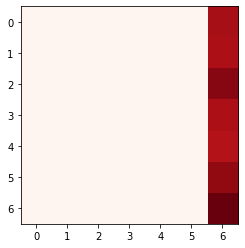

In [ ]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = VGG_model(X)
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.detach().cpu().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Train Loss =', test_loss.item())
plt.imshow(confusion_matrix(y_train, y_train_pred), cmap='Reds')
plt.show()

Test Loss = 2.253988027572632


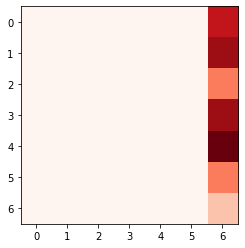

In [ ]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = VGG_model(X)      
        test_loss += criterion(y_hat, y)*len(X)/test_size
        
        y_test.extend(list(y.detach().cpu().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Test Loss =', test_loss.item())
plt.imshow(confusion_matrix(y_test, y_test_pred), cmap='Reds')
plt.show()

### Question 1. b

In [ ]:
class GoogLeNet(nn.Module):
    
    def __init__(self, n_classes, RGB_mean):
    
        super(GoogLeNet, self).__init__()
        self.RGB_mean = RGB_mean.to(device)
        self.n_classes = n_classes
        # Convolution
        # 3x224x224
        self.c1 = nn.Conv2d(3, 64, 7, stride=2, padding=3)
        # 64x112x112
        self.mp1 = nn.MaxPool2d(3, stride=2, padding=1)

        # Deep Convolution
        # 64x56x56
        self.c21 = nn.Conv2d(64, 64, 1, stride=1, padding=0)
        # 64x56x56
        self.c22 = nn.Conv2d(64, 192, 3, stride=1, padding=1)
        # 192x56x56
        self.mp2 = nn.MaxPool2d(3, stride=2)

        # Inception 3a
        # 192x28x28
        # P1
        self.c3a1 = nn.Conv2d(192, 64, 1, stride=1, padding=0)
        # P2
        self.c3a21 = nn.Conv2d(192, 96, 1, stride=1, padding=0)
        self.c3a22 = nn.Conv2d(96, 128, 3, stride=1, padding=1)
        # P3
        self.c3a31 = nn.Conv2d(192, 16, 1, stride=1, padding=0)
        self.c3a32 = nn.Conv2d(16, 32, 5, stride=1, padding=2)
        # P4
        self.mp3a4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c3a4 = nn.Conv2d(192, 32, 1, stride=1, padding=0)

        # Inception 3b
        # 256x28x28
        # P1
        self.c3b1 = nn.Conv2d(256, 128, 1, stride=1, padding=0)
        # P2
        self.c3b21 = nn.Conv2d(256, 128, 1, stride=1, padding=0)
        self.c3b22 = nn.Conv2d(128, 192, 3, stride=1, padding=1)
        # P3
        self.c3b31 = nn.Conv2d(256, 32, 1, stride=1, padding=0)
        self.c3b32 = nn.Conv2d(32, 96, 5, stride=1, padding=2)
        # P4
        self.mp3b4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c3b4 = nn.Conv2d(256, 64, 1, stride=1, padding=0)

        # 480x28x28
        # MP
        self.mp3 = nn.MaxPool2d(3, stride=2, padding=1)

        # Inception 4a
        # 480x14x14
        # P1
        self.c4a1 = nn.Conv2d(480, 192, 1, stride=1, padding=0)
        # P2
        self.c4a21 = nn.Conv2d(480, 96, 1, stride=1, padding=0)
        self.c4a22 = nn.Conv2d(96, 208, 3, stride=1, padding=1)
        # P3
        self.c4a31 = nn.Conv2d(480, 16, 1, stride=1, padding=0)
        self.c4a32 = nn.Conv2d(16, 48, 5, stride=1, padding=2)
        # P4
        self.mp4a4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c4a4 = nn.Conv2d(480, 64, 1, stride=1, padding=0)

        # Auxiliary 1
        # 512x14x14
        self.apa1 = nn.AvgPool2d(5, stride=3, padding=0)
        # 512x4x4
        self.ca1 = nn.Conv2d(512, 128, 1, stride=1)
        # 128x4x4
        self.flat1 = nn.Flatten(1, -1)
        # (128x4x4)x1
        self.fca1 = nn.Linear(2048, 1024)
        self.a1drop = nn.Dropout(0.7)
        self.a1out = nn.Linear(1024, self.n_classes)

        # Inception 4b
        # 512x14x14
        # P1
        self.c4b1 = nn.Conv2d(512, 160, 1, stride=1, padding=0)
        # P2
        self.c4b21 = nn.Conv2d(512, 112, 1, stride=1, padding=0)
        self.c4b22 = nn.Conv2d(112, 224, 3, stride=1, padding=1)
        # P3
        self.c4b31 = nn.Conv2d(512, 24, 1, stride=1, padding=0)
        self.c4b32 = nn.Conv2d(24, 64, 5, stride=1, padding=2)
        # P4
        self.mp4b4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c4b4 = nn.Conv2d(512, 64, 1, stride=1, padding=0)

        # Inception 4c
        # 512x14x14
        # P1
        self.c4c1 = nn.Conv2d(512, 128, 1, stride=1, padding=0)
        # P2
        self.c4c21 = nn.Conv2d(512, 128, 1, stride=1, padding=0)
        self.c4c22 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        # P3
        self.c4c31 = nn.Conv2d(512, 24, 1, stride=1, padding=0)
        self.c4c32 = nn.Conv2d(24, 64, 5, stride=1, padding=2)
        # P4
        self.mp4c4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c4c4 = nn.Conv2d(512, 64, 1, stride=1, padding=0)

        # Inception 4d
        # 512x14x14
        # P1
        self.c4d1 = nn.Conv2d(512, 112, 1, stride=1, padding=0)
        # P2
        self.c4d21 = nn.Conv2d(512, 144, 1, stride=1, padding=0)
        self.c4d22 = nn.Conv2d(144, 288, 3, stride=1, padding=1)
        # P3
        self.c4d31 = nn.Conv2d(512, 32, 1, stride=1, padding=0)
        self.c4d32 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
        # P4
        self.mp4d4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c4d4 = nn.Conv2d(512, 64, 1, stride=1, padding=0)

        # Auxiliary 2
        # 528x14x14
        self.apa2 = nn.AvgPool2d(5, stride=3, padding=0)
        # 528x4x4
        self.ca2 = nn.Conv2d(528, 128, 1, stride=1)
        # 128x4x4
        self.flat1 = nn.Flatten(1, -1)
        # (128x4x4)x1
        self.fca2 = nn.Linear(2048, 1024)
        self.a2drop = nn.Dropout(0.7)
        self.a2out = nn.Linear(1024, self.n_classes)

        # Inception 4e
        # 528x14x14
        # P1
        self.c4e1 = nn.Conv2d(528, 256, 1, stride=1, padding=0)
        # P2
        self.c4e21 = nn.Conv2d(528, 160, 1, stride=1, padding=0)
        self.c4e22 = nn.Conv2d(160, 320, 3, stride=1, padding=1)
        # P3
        self.c4e31 = nn.Conv2d(528, 32, 1, stride=1, padding=0)
        self.c4e32 = nn.Conv2d(32, 128, 5, stride=1, padding=2)
        # P4
        self.mp4e4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c4e4 = nn.Conv2d(528, 128, 1, stride=1, padding=0)

        # 832x14x14
        # MP
        self.mp4 = nn.MaxPool2d(3, stride=2, padding=1)

        # Inception 5a
        # 832x7x7
        # P1
        self.c5a1 = nn.Conv2d(832, 256, 1, stride=1, padding=0)
        # P2
        self.c5a21 = nn.Conv2d(832, 160, 1, stride=1, padding=0)
        self.c5a22 = nn.Conv2d(160, 320, 3, stride=1, padding=1)
        # P3
        self.c5a31 = nn.Conv2d(832, 32, 1, stride=1, padding=0)
        self.c5a32 = nn.Conv2d(32, 128, 5, stride=1, padding=2)
        # P4
        self.mp5a4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c5a4 = nn.Conv2d(832, 128, 1, stride=1, padding=0)

        # Inception 5b
        # 832x7x7
        # P1
        self.c5b1 = nn.Conv2d(832, 384, 1, stride=1, padding=0)
        # P2
        self.c5b21 = nn.Conv2d(832, 192, 1, stride=1, padding=0)
        self.c5b22 = nn.Conv2d(192, 384, 3, stride=1, padding=1)
        # P3
        self.c5b31 = nn.Conv2d(832, 48, 1, stride=1, padding=0)
        self.c5b32 = nn.Conv2d(48, 128, 5, stride=1, padding=2)
        # P4
        self.mp5b4 = nn.MaxPool2d(3, stride=1, padding=1)
        self.c5b4 = nn.Conv2d(832, 128, 1, stride=1, padding=0)

        # 1024x7x7
        self.ap = nn.AvgPool2d(7, stride=1)
        # 1024x1x1
        self.drop = nn.Dropout(0.4)
        self.flat = nn.Flatten(1, -1)
        self.out = nn.Linear(1024, self.n_classes)

    def forward(self, x, auxiliary=True):

        x = x - self.RGB_mean[None, :, None, None]

        # Layer 1
        x = self.mp1(F.relu(self.c1(x)))

        # Layer 2
        x = self.mp2(F.relu(self.c22(F.relu(self.c21(x)))))

        # Layer 3a
        x1 = F.relu(self.c3a1(x))
        x2 = F.relu(self.c3a22(F.relu(self.c3a21(x))))
        x3 = F.relu(self.c3a32(F.relu(self.c3a31(x))))
        x4 = F.relu(self.c3a4(self.mp3a4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Layer 3b
        x1 = F.relu(self.c3b1(x))
        x2 = F.relu(self.c3b22(F.relu(self.c3b21(x))))
        x3 = F.relu(self.c3b32(F.relu(self.c3b31(x))))
        x4 = F.relu(self.c3b4(self.mp3b4(x)))
        x = self.mp3(torch.cat((x1, x2, x3, x4), 1))

        # Layer 4a
        x1 = F.relu(self.c4a1(x))
        x2 = F.relu(self.c4a22(F.relu(self.c4a21(x))))
        x3 = F.relu(self.c4a32(F.relu(self.c4a31(x))))
        x4 = F.relu(self.c4a4(self.mp4a4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Auxiliary 1
        if auxiliary == True:
            z1 = self.flat1(F.relu(self.ca1(self.apa1(x))))
            z1 = self.a1out(self.a1drop(F.relu(self.fca1(z1))))
        else:
            z1 = None

        # Layer 4b
        x1 = F.relu(self.c4b1(x))
        x2 = F.relu(self.c4b22(F.relu(self.c4b21(x))))
        x3 = F.relu(self.c4b32(F.relu(self.c4b31(x))))
        x4 = F.relu(self.c4b4(self.mp4b4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Layer 4c
        x1 = F.relu(self.c4c1(x))
        x2 = F.relu(self.c4c22(F.relu(self.c4c21(x))))
        x3 = F.relu(self.c4c32(F.relu(self.c4c31(x))))
        x4 = F.relu(self.c4c4(self.mp4c4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Layer 4d
        x1 = F.relu(self.c4d1(x))
        x2 = F.relu(self.c4d22(F.relu(self.c4d21(x))))
        x3 = F.relu(self.c4d32(F.relu(self.c4d31(x))))
        x4 = F.relu(self.c4d4(self.mp4d4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Auxiliary 2
        if auxiliary == True:
            z2 = self.flat(F.relu(self.ca2(self.apa2(x))))
            z2 = self.a2out(self.a2drop(F.relu(self.fca2(z2))))
        else:
            z2 = None

        # Layer 4e
        x1 = F.relu(self.c4e1(x))
        x2 = F.relu(self.c4e22(F.relu(self.c4e21(x))))
        x3 = F.relu(self.c4e32(F.relu(self.c4e31(x))))
        x4 = F.relu(self.c4e4(self.mp4e4(x)))
        x = self.mp4(torch.cat((x1, x2, x3, x4), 1))

        # Layer 5a
        x1 = F.relu(self.c5a1(x))
        x2 = F.relu(self.c5a22(F.relu(self.c5a21(x))))
        x3 = F.relu(self.c5a32(F.relu(self.c5a31(x))))
        x4 = F.relu(self.c5a4(self.mp5a4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Layer 5b
        x1 = F.relu(self.c5b1(x))
        x2 = F.relu(self.c5b22(F.relu(self.c5b21(x))))
        x3 = F.relu(self.c5b32(F.relu(self.c5b31(x))))
        x4 = F.relu(self.c5b4(self.mp5b4(x)))
        x = torch.cat((x1, x2, x3, x4), 1)

        # Final Output
        x = self.out(self.flat(self.drop(self.ap(x))))

        return x, z1, z2

    
    def predict(self, x):

        y_hat = self.forward(x)
        y_hat = torch.argmax(y_hat, axis=1)
        return y_hat

In [ ]:
classifier = GoogLeNet(7, RGB_mean)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.001, momentum=0.9)
classifier = classifier.to(device)

In [ ]:

old_loss = np.inf

max_epoch = 100

for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
        
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat, y_hat1, y_hat2 = classifier(X)
        
        # Calculate Loss (Cross Entropy)
        loss_main = criterion(y_hat, y)
        loss1 = criterion(y_hat1, y)
        loss2 = criterion(y_hat2, y)

        # Weighted Loss
        loss = loss_main + 0.3*loss1 + 0.3*loss2

        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)16/train_size
    
    print('Epoch', epoch+1, ': Loss =', running_loss)
    
    # if abs(running_loss-old_loss)/running_loss < 1e-5:
    #     print('Converged')
    #     break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 3.1238052952995696
Epoch 2 : Loss = 3.1230392854803535
Epoch 3 : Loss = 3.1222557041287837
Epoch 4 : Loss = 3.1212302284373643
Epoch 5 : Loss = 3.122042758954942
Epoch 6 : Loss = 3.12227149458297
Epoch 7 : Loss = 3.121719347059934
Epoch 8 : Loss = 3.120970004942359
Epoch 9 : Loss = 3.120733320920725
Epoch 10 : Loss = 3.120026963928435
Epoch 11 : Loss = 3.1203691568939527
Epoch 12 : Loss = 3.1206211528711614
Epoch 13 : Loss = 3.119851793561663
Epoch 14 : Loss = 3.119395412219111
Epoch 15 : Loss = 3.120387937964462
Epoch 16 : Loss = 3.1187823491644777
Epoch 17 : Loss = 3.1189311622327214
Epoch 18 : Loss = 3.1190011027798
Epoch 19 : Loss = 3.1165639232675377
Epoch 20 : Loss = 3.117623810984117
Epoch 21 : Loss = 3.1180430555177487
Epoch 22 : Loss = 3.1181528709491366
Epoch 23 : Loss = 3.115429894849398
Epoch 24 : Loss = 3.1176778414523563
Epoch 25 : Loss = 3.115609398286933
Epoch 26 : Loss = 3.1165187848984988
Epoch 27 : Loss = 3.1164356989312254
Epoch 28 : Loss = 3.115076

Train Loss = 1.9430598020553589


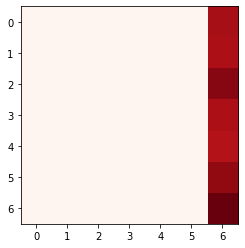

In [ ]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat, _, _ = classifier(X)      
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.detach().cpu().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Train Loss =', train_loss.item())
plt.imshow(confusion_matrix(y_train, y_train_pred), cmap='Reds')
plt.show()

In [ ]:
acc = accuracy_score(y_train, y_train_pred)
prec = precision_score(y_train, y_train_pred, average='macro')
f1 = f1_score(y_train, y_train_pred, average='macro')

print('Train Accuracy =', acc, 'Train Precision =', prec, 'Train F1 =', f1)

Train Accuracy = 0.1602787456445993 Train Precision = 0.022896963663514184 Train F1 = 0.039468039468039465


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss = 1.9689445495605469


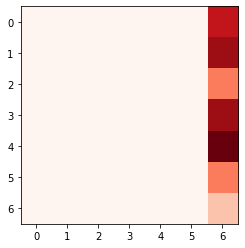

In [ ]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat, _, _ = classifier(X)      
        test_loss += criterion(y_hat, y)*len(X)/test_size
        
        y_test.extend(list(y.detach().cpu().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Test Loss =', test_loss.item())
plt.imshow(confusion_matrix(y_test, y_test_pred), cmap='Reds')
plt.show()

In [ ]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Train Accuracy =', acc, 'Train Precision =', prec, 'Train F1 =', f1)

Train Accuracy = 0.047619047619047616 Train Precision = 0.006802721088435374 Train F1 = 0.012987012987012986


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Question 2

In [ ]:
class CNN2(nn.Module):
    
    def __init__(self, n_classes):
        super(CNN2, self).__init__()

        self.n_classes = n_classes
        # 3x224x224
        self.cl1 = nn.Conv2d(3, 4, 3, stride=1, padding=1)
        # 4x224x224
        self.pl1 = nn.AvgPool2d(2, stride=2)
        # 4x112x112
        self.cl2 = nn.Conv2d(4, 16, 3, stride=1, padding=1)
        # 16x112x112
        self.pl2 = nn.AvgPool2d(2, stride=2)

        # 16x56x56
        self.flat = nn.Flatten(1, -1)
        # (16x56x56)x1
        self.out = nn.Linear(16*56*56, self.n_classes)


    def forward(self, x):
        
        x = self.pl1(F.relu(self.cl1(x)))
        x = self.pl2(F.relu(self.cl2(x)))
        x = self.out(self.flat(x))

        return x


    def predict(self, x):

        y_hat = self.forward(x)
        y_hat = torch.argmax(y_hat, axis=1)
        return y_hat

In [ ]:
classifier = CNN2(7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.0001, momentum=0.9)
classifier = classifier.to(device)

In [ ]:
old_loss = np.inf
from IPython.display import clear_output
losses = []
max_epoch = 200
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
            
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = classifier(X)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)

        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size

    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)

    
    if (abs(running_loss-old_loss)/running_loss < 0.2) and epoch>=10 and running_loss<0.01:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 8.51608510382915
Epoch 2 : Loss = 1.9994171861987495
Epoch 3 : Loss = 1.9447825997548651
Epoch 4 : Loss = 1.9335377008657422
Epoch 5 : Loss = 1.924046891906951
Epoch 6 : Loss = 1.915209303749563
Epoch 7 : Loss = 1.8966690609264043
Epoch 8 : Loss = 1.880748568926954
Epoch 9 : Loss = 1.8649288818811292
Epoch 10 : Loss = 1.8444972038269043
Epoch 11 : Loss = 1.8139404183065437
Epoch 12 : Loss = 1.783672104729177
Epoch 13 : Loss = 1.748245834888897
Epoch 14 : Loss = 1.6984773778749263
Epoch 15 : Loss = 1.6479445400969077
Epoch 16 : Loss = 1.5252120798057796
Epoch 17 : Loss = 1.3692599933737246
Epoch 18 : Loss = 1.1686137353917032
Epoch 19 : Loss = 0.993157974103602
Epoch 20 : Loss = 0.7433030617777064
Epoch 21 : Loss = 0.5656542364728576
Epoch 22 : Loss = 0.4901453439366943
Epoch 23 : Loss = 0.36426011267854774
Epoch 24 : Loss = 0.3462182510812939
Epoch 25 : Loss = 0.3036954419538119
Epoch 26 : Loss = 0.10046271201002474
Epoch 27 : Loss = 0.06260648136147225
Epoch 28 : Loss

Train Loss = 0.007632026448845863


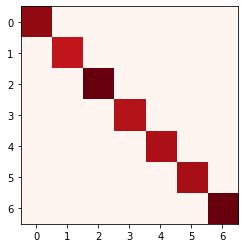

In [ ]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.detach().cpu().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Train Loss =', train_loss.item())
plt.imshow(confusion_matrix(y_train, y_train_pred), cmap='Reds')
plt.show()

In [ ]:
acc_tr = accuracy_score(y_train, y_train_pred)
prec_tr = precision_score(y_train, y_train_pred, average='weighted')
f1_tr = f1_score(y_train, y_train_pred, average='weighted')

print('Train Accuracy =', acc_tr, 'Train Precision =', prec_tr, 'Train F1 =', f1_tr)

Train Accuracy = 1.0 Train Precision = 1.0 Train F1 = 1.0


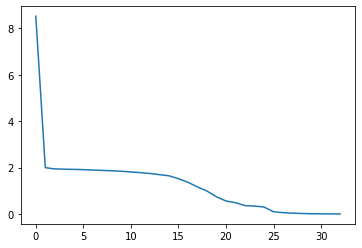

In [ ]:
plt.plot(losses)
plt.show()

Test Loss = 3.1113786697387695


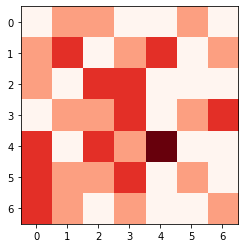

In [ ]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        test_loss += criterion(y_hat, y)*len(X)/test_size
        
        y_test.extend(list(y.detach().cpu().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Test Loss =', test_loss.item())
plt.imshow(confusion_matrix(y_test, y_test_pred), cmap='Reds')
plt.show()

In [ ]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)

Test Accuracy = 0.2619047619047619 Test Precision = 0.28922902494331065 Test F1 = 0.25354090354090353


## Question 3

In [44]:
class CNN3(nn.Module):
    
    def __init__(self, n_classes, k=4):
        super(CNN3, self).__init__()

        self.n_classes = n_classes
        # 3x224x224
        self.cl1 = nn.Conv2d(3, 4, 3, stride=1, padding=1)
        # 4x224x224
        self.pl1 = nn.AvgPool2d(2, stride=2)
        # 4x112x112
        self.cl2 = nn.Conv2d(4, 16, 3, stride=1, padding=1)
        # 16x112x112
        self.pl2 = nn.AvgPool2d(2, stride=2)

        # NetVLAD
        self.K = k
        self.nv_conv = nn.Conv2d(16, self.K, 1)
        self.nv_soft_ass = nn.Softmax2d()

        # NetVLAD Parameter
        self.c = nn.Parameter(torch.rand(self.K, 16))
        
        # Flatten to get h
        self.flat = nn.Flatten(1, -1)

        # Output layer
        self.out = nn.Linear(self.K*16, self.n_classes)
        

    def forward(self, x):
        
        # print(x.shape)
        x = self.pl1(F.relu(self.cl1(x)))
        # print(x.shape)
        x = self.pl2(F.relu(self.cl2(x)))
        # print(x.shape)
        
        # NetVLAD Step 1
        a = self.nv_soft_ass(self.nv_conv(x))

        # NetVLAD Step 2
        for k in range(self.K):
            a_k = a[:, k, :, :]
            c_k = self.c[k, :]
            temp = (x - c_k.reshape(1, -1, 1, 1))*a_k.unsqueeze(1)
            z_k = torch.sum(temp, axis=(2, 3))
            if k==0:
                Z = z_k.unsqueeze(1)
            else:
                Z = torch.cat((Z, z_k.unsqueeze(1)), 1)
        
        # Flatten
        Z = self.flat(Z)
        # print('Z shape', Z.shape)
        Z = self.out(Z)

        return Z


    def predict(self, x):

        y_hat = self.forward(x)
        y_hat = torch.argmax(y_hat, axis=1)
        return y_hat

In [45]:
classifier = CNN3(7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.0001, momentum=0.9)
classifier = classifier.to(device)

In [ ]:
old_loss = np.inf
from IPython.display import clear_output
losses = []
max_epoch = 200
for epoch in range(max_epoch):

    running_loss = 0.0
    
    for data in trainloader:
            
        X, y = data[0].to(device), data[1].to(device)
        
        optimizer.zero_grad()
        
        # Forward
        y_hat = classifier(X)
        
        # Calculate Loss (Cross Entropy)
        loss = criterion(y_hat, y)

        # Backpropagation
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        
        running_loss += loss.item()*len(X)/train_size

    print('Epoch', epoch+1, ': Loss =', running_loss)
    losses.append(running_loss)

    
    if (abs(running_loss-old_loss)/running_loss < 0.2) and epoch>=10 and running_loss<0.01:
        print('Converged')
        break
    
    old_loss = running_loss

print('Finished Training')

Epoch 1 : Loss = 85807623.2677891
Epoch 2 : Loss = 28301.72832507622
Epoch 3 : Loss = 18408.02954186629
Epoch 4 : Loss = 43676.23143510452
Epoch 5 : Loss = 43213.82771668119
Epoch 6 : Loss = 126600.11846689894
Epoch 7 : Loss = 240719.85224303138
Epoch 8 : Loss = 215393.4227324695
Epoch 9 : Loss = 71398.49858449477
Epoch 10 : Loss = 141169.75748584495
Epoch 11 : Loss = 207208.68343042248
Epoch 12 : Loss = 56377.06017258275
Epoch 13 : Loss = 39714.29333623694
Epoch 14 : Loss = 69156.5947027439
Epoch 15 : Loss = 49089.8818121189
Epoch 16 : Loss = 115871.9918336237
Epoch 17 : Loss = 96327.01796602787
Epoch 18 : Loss = 180568.33177264806
Epoch 19 : Loss = 158264.56037674216
Epoch 20 : Loss = 189712.8424978223
Epoch 21 : Loss = 186683.625
Epoch 22 : Loss = 348658.04322735185
Epoch 23 : Loss = 444821.3343858886
Epoch 24 : Loss = 376555.8679224739
Epoch 25 : Loss = 439843.20198170736
Epoch 26 : Loss = 271717.7355182927
Epoch 27 : Loss = 346034.916104094
Epoch 28 : Loss = 582051.9578614983
Epoc

Train Loss = 21922.796875


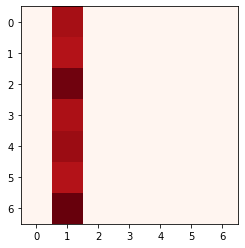

In [34]:
with torch.no_grad():
    
    train_loss = 0.0
    y_train = []
    y_train_pred = []

    for data in trainloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        train_loss += criterion(y_hat, y)*len(X)/train_size
        
        y_train.extend(list(y.detach().cpu().numpy()))
        y_train_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Train Loss =', train_loss.item())
plt.imshow(confusion_matrix(y_train, y_train_pred), cmap='Reds')
plt.show()

In [35]:
acc_tr = accuracy_score(y_train, y_train_pred)
prec_tr = precision_score(y_train, y_train_pred, average='weighted')
f1_tr = f1_score(y_train, y_train_pred, average='weighted')

print('Train Accuracy =', acc_tr, 'Train Precision =', prec_tr, 'Train F1 =', f1_tr)

Train Accuracy = 0.13240418118466898 Train Precision = 0.017530867195182653 Train F1 = 0.030962208523184133


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Loss = 57528.66796875


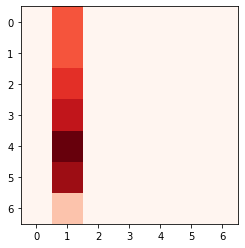

In [33]:
with torch.no_grad():
    
    test_loss = 0.0
    y_test = []
    y_test_pred = []

    for data in testloader:

        X, y = data[0].to(device), data[1].to(device)
        y_hat = classifier(X)      
        test_loss += criterion(y_hat, y)
        
        y_test.extend(list(y.detach().cpu().numpy()))
        y_test_pred.extend(list(torch.argmax(y_hat, axis=1).detach().cpu().numpy()))

print('Test Loss =', test_loss.item())
plt.imshow(confusion_matrix(y_test, y_test_pred), cmap='Reds')
plt.show()

In [ ]:
acc = accuracy_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred, average='macro')
f1 = f1_score(y_test, y_test_pred, average='macro')

print('Test Accuracy =', acc, 'Test Precision =', prec, 'Test F1 =', f1)